<a href="https://colab.research.google.com/github/amfei/Statistical_Inference/blob/main/Statistical_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

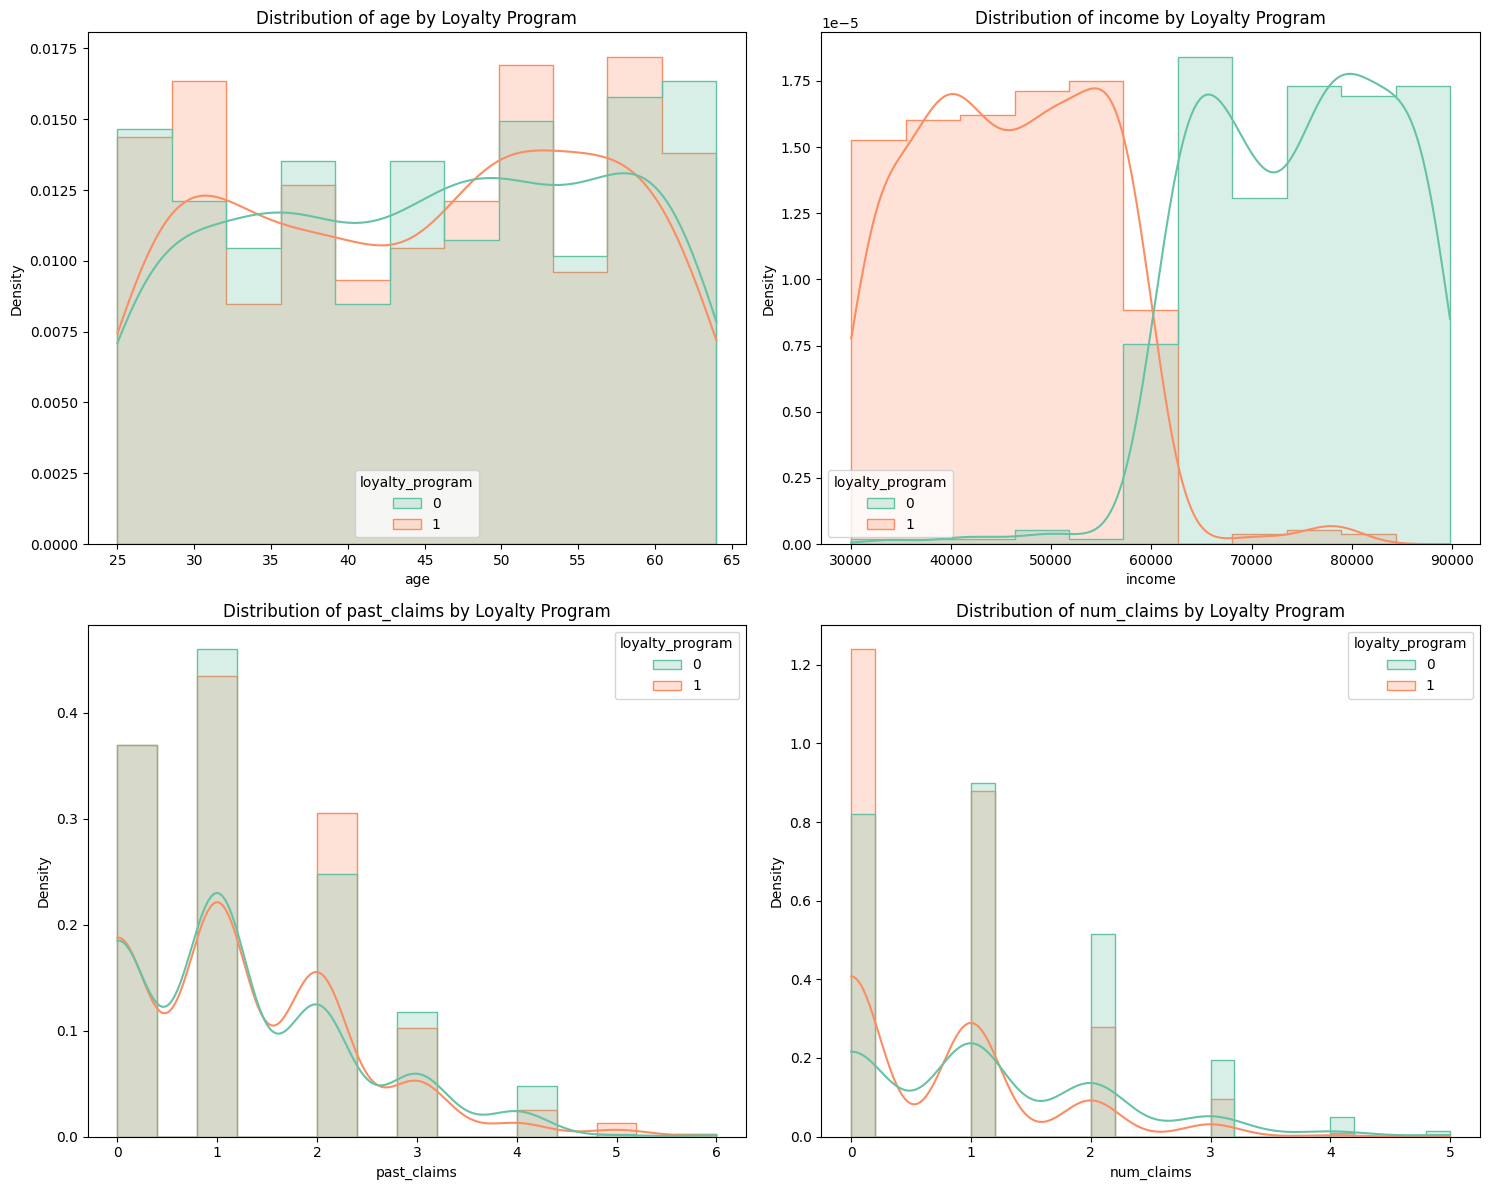

In [29]:
# Estimate the causal effect of a loyalty program on the number of insurance claims.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

# Step 1: Generate Synthetic Data
np.random.seed(42)
n_samples = 1000

#      Variable	               Role	                        Notes
# age, income, past_claims	Confounders	       affect both treatment & outcome
# loyalty_program	          Treatment	         binary 0/1, influenced by confounders
# num_claims	              Outcome	           count, affected by past_claims and loyalty_program


# Covariates (Confounders)
age = np.random.randint(25, 65, n_samples)  # More realistic working-age range
income = np.random.randint(30000, 90000, n_samples)  # More balanced distribution
past_claims = np.random.poisson(1.2, n_samples)  # Slightly lower past claims on average

# Adjusted Treatment Variable: Loyalty Program Enrollment
# Ensuring more realistic overlap in propensity scores
#assume lower-income customers are more likely to participate in basic loyalty programs.

logit_val = -0.015 * (income - 60000) - 0.025 * (age - 45) + 0.15 * past_claims
logit_val = np.clip(logit_val, -4, 4)  # Prevent extreme values to ensure overlap
loyalty_program = np.random.binomial(1, p=1 / (1 + np.exp(-logit_val)), size=n_samples)

# Outcome Variable: Number of Insurance Claims (affected by loyalty program)
num_claims = np.random.poisson(1 + 0.1 * past_claims - 0.4 * loyalty_program, n_samples)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'past_claims': past_claims,
    'loyalty_program': loyalty_program,
    'num_claims': num_claims
})
summary_stats = df.describe()

summary_stats


# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Plot distributions for each feature
features = ['age', 'income', 'past_claims', 'num_claims']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=feature, hue='loyalty_program', kde=True, palette='Set2', element='step', stat='density')
    plt.title(f"Distribution of {feature} by Loyalty Program")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [ ]:
# Compute statistics grouped by loyalty program
grouped_stats = df.groupby("loyalty_program").agg({
    "age": ["mean", "std", "min", "max"],
    "income": ["mean", "std", "min", "max"],
    "past_claims": ["mean", "std", "min", "max"],
    "num_claims": ["mean", "std", "min", "max"]
})
grouped_stats

In [ ]:
# Plot distribution of claims before matching
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['loyalty_program'] == 1]['num_claims'], label='Treated (Loyalty Program)', fill=True)
sns.kdeplot(df[df['loyalty_program'] == 0]['num_claims'], label='Control (No Loyalty Program)', fill=True)
plt.xlabel("Number of Claims")
plt.ylabel("Density")
plt.title("Distribution of Claims Before Matching")
plt.legend()
plt.show()
df

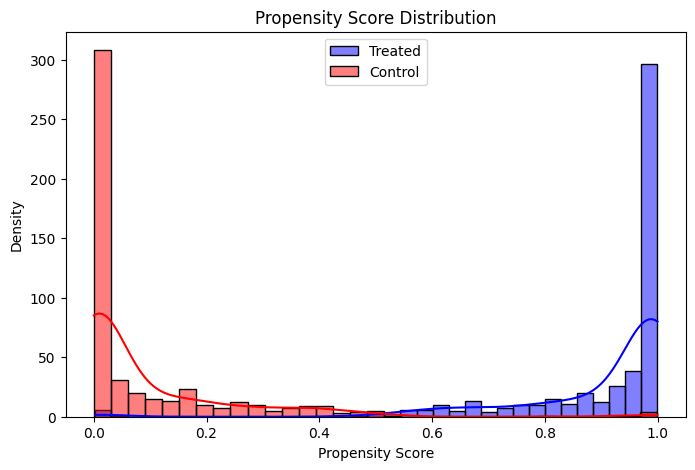

,age,income,past_claims,loyalty_program,num_claims,propensity_score
0,63,74327,0,0,1,0.009782
1,53,33368,2,1,2,0.999761
2,39,33797,2,1,1,0.999743
3,32,77882,0,0,0,0.003757
4,45,43718,2,1,2,0.994447
...,...,...,...,...,...,...
995,32,56958,2,1,1,0.762806
996,52,56017,2,1,1,0.797889
997,55,41171,4,1,0,0.998051
998,33,89141,0,0,2,0.000117


In [16]:
from sklearn.preprocessing import StandardScaler
# Step 2: Estimate Propensity Scores : Uses logistic regression to predict the probability of enrollment.

X = df[['age', 'income', 'past_claims']]
y = df['loyalty_program']


# Standardizing Features to Improve Logistic Regression Performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic Regression Model for Propensity Score Estimation
propensity_model = LogisticRegression(max_iter=500, solver='lbfgs')
propensity_model.fit(X_scaled, y)

# Compute Propensity Scores (Probability of Enrolling)
df['propensity_score'] = propensity_model.predict_proba(X_scaled)[:, 1]

# EXPECTED OUTCOME: Each customer gets an estimated probability of enrolling in the loyalty program.

# INTERPRETATION: Customers with similar propensity scores have similar characteristics, allowing fair comparison.


# Plot propensity score distribution
plt.figure(figsize=(8, 5))
sns.histplot(df[df['loyalty_program'] == 1]['propensity_score'], label="Treated", kde=True, color="blue", alpha=0.5)
sns.histplot(df[df['loyalty_program'] == 0]['propensity_score'], label="Control", kde=True, color="red", alpha=0.5)
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Propensity Score Distribution")
plt.legend()
plt.show()
df

### With **matching**, we ensure that the enrolled and non-enrolled groups have **similar distributions of income, age, and past claims**.

### This means that any remaining difference in claims must be due to the **loyalty program** itself, since other confounding effects are balanced.


In [17]:
# Step 3: Matching (Finding Similar Customers)
treated = df[df['loyalty_program'] == 1]  # Customers enrolled in the loyalty program
control = df[df['loyalty_program'] == 0]  # Customers not enrolled

# Nearest Neighbors Matching using Propensity Scores: Matching balances confounding variables, making the comparison fair.
# Matching ensures we only compare statistically similar customers, eliminating bias.
# Find similar untreated customers (control group):

# For each treated customer (loyalty_program = 1), we find the nearest untreated customer (loyalty_program = 0) with a similar propensity score.
# This is done using Nearest Neighbors Matching, which finds the control group customer whose propensity score is closest to a treated customer.
# The control customer is selected without replacement to ensure independence.

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])  # Find closest control

# Matched Control Group
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)

# Create a Balanced Matched Dataset
matched_df = pd.concat([treated.reset_index(drop=True), matched_control], axis=0)

# We paired each treated customer with their closest control.
# Now, our treated and control groups should have similar distributions of age, income, and past claims.


# EXPECTED OUTCOME: A control group similar to the treated group in terms of age, income, and past claims.

# INTERPRETATION: Now, the only key difference between the two groups should be whether they enrolled or not.
matched_df

,age,income,past_claims,loyalty_program,num_claims,propensity_score
0,53,33368,2,1,2,0.999761
1,39,33797,2,1,1,0.999743
2,45,43718,2,1,2,0.994447
3,43,41053,1,1,1,0.997163
4,47,52116,2,1,0,0.930530
...,...,...,...,...,...,...
496,40,51754,1,0,0,0.929653
497,38,40361,0,0,1,0.997379
498,32,55963,1,0,2,0.789156
499,32,55963,1,0,2,0.789156


T-test: t-statistic = -6.524, p-value = 0.000


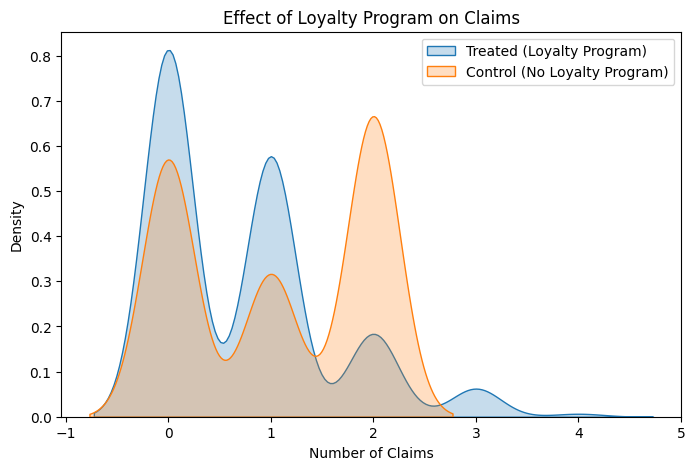

In [18]:
# Once we have a balanced control group, we can compare the number of claims between the two groups.

# Comparing Outcomes
# The treated group consists of customers who enrolled in the loyalty program.
# The control group consists of customers who didn’t enroll, but are otherwise very similar.
# We compare the average number of claims in both groups.

# Step 4: Outcome Analysis - Compare Claims in Treated vs. Matched Control Group
treated_claims = matched_df[matched_df['loyalty_program'] == 1]['num_claims']
control_claims = matched_df[matched_df['loyalty_program'] == 0]['num_claims']

# Perform T-test
t_stat, p_value = ttest_ind(treated_claims, control_claims)
print(f"T-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Visualizing the Effect
plt.figure(figsize=(8, 5))
sns.kdeplot(treated_claims, label='Treated (Loyalty Program)',  fill=True)
sns.kdeplot(control_claims, label='Control (No Loyalty Program)', fill=True)
plt.xlabel("Number of Claims")
plt.ylabel("Density")
plt.title("Effect of Loyalty Program on Claims")
plt.legend()
plt.show()


# If the control group (no loyalty program) has a higher average number of claims, it suggests that the loyalty program reduces claims.
# If the distributions overlap completely, it suggests no effect.


In [19]:
# Compute descriptive statistics for treated and control groups
treated_mean = np.mean(treated_claims)
control_mean = np.mean(control_claims)

treated_median = np.median(treated_claims)
control_median = np.median(control_claims)

treated_variance = np.var(treated_claims)
control_variance = np.var(control_claims)

# Store results in a DataFrame for easy comparison
stats_df = pd.DataFrame({
    "Statistic": ["Mean", "Median", "Variance"],
    "Treated (Loyalty Program)": [treated_mean, treated_median, treated_variance],
    "Control (No Loyalty Program)": [control_mean, control_median, control_variance]
})
stats_df

,Statistic,Treated (Loyalty Program),Control (No Loyalty Program)
0,Mean,0.704591,1.061876
1,Median,1.000000,1.000000
2,Variance,0.707145,0.792579


In [20]:
# Calculate ATE
ATE = treated_claims.mean() - control_claims.mean()
ATE


np.float64(-0.3572854291417167)

## A negative value  means that being in the loyalty program causes 0.42 fewer claims on average per customer.

Causal Estimate (ATE): -0.3860071431747374
Refute: Use a Placebo Treatment
Estimated effect:-0.3860071431747374
New effect:0.0027884977317045355
p value:0.96



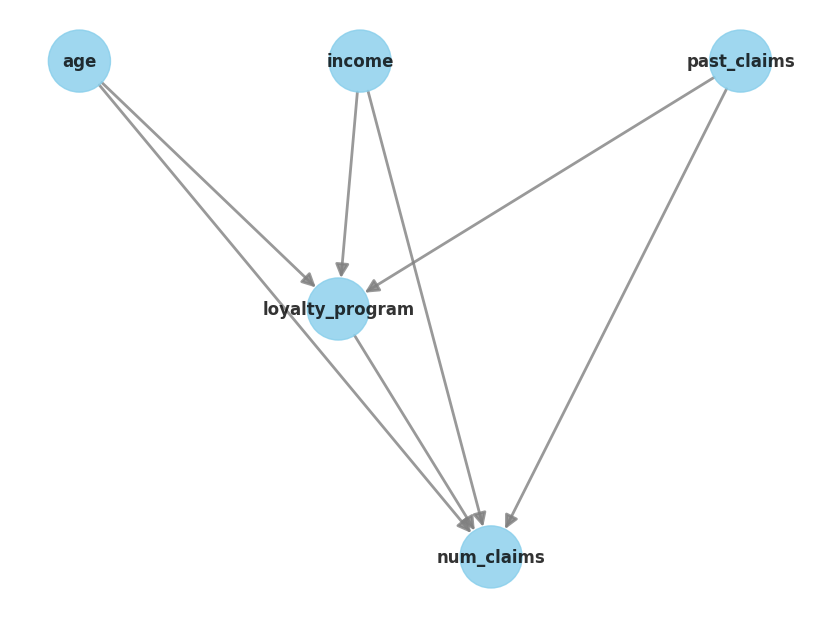

In [21]:
#!pip install dowhy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import dowhy
from dowhy import CausalModel
import pandas as pd

df.drop(['propensity_score'], axis = 1, inplace = True)
# Step 1: Define the causal model
model = CausalModel(
    data=df,
    treatment="loyalty_program",
    outcome="num_claims",
    common_causes=["age", "income", "past_claims"]
)

# Step 2: Identify causal effect
identified_estimand = model.identify_effect()

# Step 3: Estimate causal effect using regression
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")

print("Causal Estimate (ATE):", causal_estimate.value)

# Step 4: Refute the estimate using a placebo test
refute_result = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refute_result)
# Step 2: Visualize the causal graph
model.view_model(layout="dot")  # will save a .png file or render inline in Jupyter Notebook

In [11]:
# Identify estimand
identified_estimand = model.identify_effect()

# Estimate causal effect using IPW
ipw_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="ate"
)

# Store the result in a DataFrame
ipw_result_df = pd.DataFrame({
    "Method": ["Inverse Probability Weighting (IPW)"],
    "Causal Estimate (ATE)": [ipw_estimate.value]
})

ipw_result_df

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Method,Causal Estimate (ATE)
0,Inverse Probability Weighting (IPW),-0.400335


In [22]:
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm


# Compute Cohen's d (Effect Size) : Effect size measures how meaningful a difference is, beyond just statistical significance.
# Small Effect: 𝑑<0.2
# Medium Effect: 0.2≤𝑑<0.5
# Large Effect: d≥0.8

s_pooled = np.sqrt(((len(treated_claims) - 1) * np.var(treated_claims) +
                    (len(control_claims) - 1) * np.var(control_claims)) /
                   (len(treated_claims) + len(control_claims) - 2))
cohens_d = (np.mean(treated_claims) - np.mean(control_claims)) / s_pooled
cohens_d
#Since Cohen’s d = -0.4, this means the loyalty program moderately reduces claims.If d were closer to -1, the effect would be stronger.


np.float64(-0.412595760538466)

In [23]:
#Compute Required Sample Size (Power Analysis)
# Even if a t-test shows statistical significance, we need to ensure our sample size is large enough to detect a real effect.
# We use power analysis to determine the minimum sample size required to detect an effect of a given size.
# Factors Affecting Sample Size:
# Effect size (Cohen’s d) → Larger effect sizes need smaller samples.
# Significance Level (𝛼) → Typically set to 0.05 (5% chance of false positive).
# Power (1−β) → Typically set to 0.8 (80% probability of detecting a true effect).

analysis = TTestIndPower()
required_sample_size = analysis.solve_power(effect_size=cohens_d, alpha=0.05, power=0.8, ratio=1)
required_sample_size

93.18208267119799

In [24]:

#Z-scores allow us to compare claim behavior across treated and control groups on a common scale.
# Step 4: Compute Z-Scores for a few sample claims
z_scores_treated = (treated_claims[:10] - np.mean(treated_claims)) / np.std(treated_claims)
z_scores_control = (control_claims[:10] - np.mean(control_claims)) / np.std(control_claims)
# Display Z-Scores for first 10 customers
z_scores_df = pd.DataFrame({
    "Treated Z-Scores": z_scores_treated,
    "Control Z-Scores": z_scores_control
})
z_scores_df

,Treated Z-Scores,Control Z-Scores
0,1.540469,-1.192759
1,0.351293,-1.192759
2,1.540469,1.053753
3,0.351293,-0.069503
4,-0.837882,-1.192759
5,-0.837882,-1.192759
6,-0.837882,1.053753
7,-0.837882,-1.192759
8,0.351293,-0.069503
9,-0.837882,-0.069503


In [25]:
# Store results in a DataFrame for easy viewing
analysis_results = pd.DataFrame({
    "Statistic": ["T-Statistic",'ATE', "P-Value", "Cohen's d (Effect Size)", "Required Sample Size"],
    "Value": [t_stat, ATE, p_value, cohens_d, required_sample_size],
    "Interpretation": [
        "Strong negative effect, indicating fewer claims in the loyalty program",
        "Negative ATE suggests the loyalty program reduces the number of claims",
        "Very small p-value confirms statistical significance (rejects null hypothesis)",
        "Moderate negative effect size, indicating meaningful reduction in claims",
        "Sample size is sufficient to detect a reliable effect"
    ]
})

analysis_results

,Statistic,Value,Interpretation
0,T-Statistic,-6.523712e+00,"Strong negative effect, indicating fewer claim..."
1,ATE,-3.572854e-01,Negative ATE suggests the loyalty program redu...
2,P-Value,1.087569e-10,Very small p-value confirms statistical signif...
3,Cohen's d (Effect Size),-4.125958e-01,"Moderate negative effect size, indicating mean..."
4,Required Sample Size,9.318208e+01,Sample size is sufficient to detect a reliable...
